In [206]:
# Импорт необходимых библиотек

import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
%matplotlib inline
import requests
from bs4 import BeautifulSoup
import category_encoders as ce
from geopy.distance import geodesic
from geopy import distance
import re
from sklearn import preprocessing

from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

import time


In [207]:
pd.set_option('display.max_columns', None)

# зафиксируем версию пакетов, random_seed, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt
RANDOM_SEED = 42

# Загружаем данные:
df_train = pd.read_csv('hotels_train.csv') # датасет для обучения
df_test = pd.read_csv('hotels_test.csv') # датасет для предсказания
sample_submission = pd.read_csv('submission.csv') # самбмишн

In [208]:
# Объединив датасеты для обучения и предсказания, видим пропуски в двух столбцах: с широтой (lat) и долготой (lng) расположения отеля. 
# Пропуски так же есть в целевом признаке из-за объединения тестовой и тренировочной выборки, которые мы не будем обрабатывать. 
# Типы столбцов соответствуют хранимой в них информации.

df = pd.concat([df_train, df_test], axis = 0, join = 'outer', ignore_index = True)
df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515738 non-null  object 
 1   additional_number_of_scoring                515738 non-null  int64  
 2   review_date                                 515738 non-null  object 
 3   average_score                               515738 non-null  float64
 4   hotel_name                                  515738 non-null  object 
 5   reviewer_nationality                        515738 non-null  object 
 6   negative_review                             515738 non-null  object 
 7   review_total_negative_word_counts           515738 non-null  int64  
 8   total_number_of_reviews                     515738 non-null  int64  
 9   positive_review                             515738 non-null  object 
 

In [209]:
# Для того, чтобы заполнить данные в пропущенных значениях, создадим два признака из адреса отеля - страну и город.

# Функция для получения признака "Страна"
def get_country(address):
    country = address.split(' ')[-2:]
    country = str(country).replace(',', '').replace("['", "").replace("']", "").replace("'", "")
    if country == 'United Kingdom':
        return 'United Kingdom'
    if country == 'Paris France':
        return 'France'
    if country == 'Amsterdam Netherlands':
        return 'Netherlands'
    if country == 'Milan Italy':
        return 'Italy'
    if country == 'Vienna Austria':
        return 'Austria'
    if country == 'Barcelona Spain':
        return 'Spain'
    else:
        return 'other'
    
df['country'] = df['hotel_address'].apply(get_country)

# Функция для получения признака "Город"
def city(country):
    if country == 'United Kingdom':
        return 'London'
    if country == 'France':
        return 'Paris'
    if country == 'Netherlands':
        return 'Amsterdam'
    if country == 'Italy':
        return 'Milan'
    if country == 'Austria':
        return 'Vienna'
    if country == 'Spain':
        return 'Barcelona'

df['city'] = df['country'].apply(city)

In [210]:
# Так как уникальных значений стран в наших данных немного, 
# восстановлю данные о координатах модальным значениями по стране (а значит по городу, в к-м расположен отель,
# так как отели из нашей выборки расположены все в столицах)

# Сгруппирую данные для получения нужныз модальных значений
df.groupby(['country'])['lng'].agg(pd.Series.mode)
df.groupby(['country'])['lat'].agg(pd.Series.mode)

country
Austria           48.214662
France            48.879484
Italy             45.533137
Netherlands       52.370545
Spain             41.371308
United Kingdom    51.501910
Name: lat, dtype: float64

In [211]:
# Заполню пропуски полученными на предыдущем шаге данными:
df[df['country'] == 'Austria'] = df[df['country'] == 'Austria'].fillna({'lng':16.362799, 'lat':48.214662})
df[df['country'] == 'France'] = df[df['country'] == 'France'].fillna({'lng':2.355654, 'lat':48.879484})
df[df['country'] == 'Italy'] = df[df['country'] == 'Italy'].fillna({'lng':9.171102, 'lat':45.533137})
df[df['country'] == 'Netherlands'] = df[df['country'] == 'Netherlands'].fillna({'lng':4.888644, 'lat':52.370545})
df[df['country'] == 'Spain'] = df[df['country'] == 'Spain'].fillna({'lng':2.181698, 'lat':41.371308})
df[df['country'] == 'United Kingdom'] = df[df['country'] == 'United Kingdom'].fillna({'lng':-0.023221, 'lat':51.501910})

In [212]:
# Создаю: 1) признак с координатами отеля;   
# 2) признак с координатами центра города (за центр города я брала координаты с Google Maps, по точке в центре города)

def get_coordinate(lat, lng):
    return (float(lat), float(lng))

def capital_coordinate(country):
    if country == 'United Kingdom':
        return (float(51.50936092785646), float(-0.12416095345639586))
    if country == 'France':
        return (float(48.853229), float(2.342797))
    if country == 'Netherlands':
        return (float(52.37176471692262), float(4.895930820099642))
    if country == 'Italy':
        return (float(45.46986), float(9.18499))
    if country == 'Austria':
        return (float(48.20471741160276), float(16.37049992180316))
    if country == 'Spain':
        return (float(41.395704279217775), float(2.172020436193314))
        

df['hotel_coordinate'] = df.apply(lambda row: get_coordinate(row['lat'], row['lng']), axis = 1)
df['center_coordinate'] = df['country'].apply(capital_coordinate)

In [213]:
# Из признака даты получим два новых признака - год и месяц. Так же создадаим признак сезона.

df['review_date'] = pd.to_datetime(df['review_date'])
df['year'] = df['review_date'].dt.year
df['month'] = df['review_date'].dt.month


def get_season(data):
    if data in [12, 1, 2]:
        return 'winter'
    if data in [3, 4, 5]:
        return 'spring'
    if data in [6, 7, 8]:
        return 'summer'
    if data in [9, 10, 11]:
        return 'autumn'
    
df['season'] = df['month'].apply(get_season)

In [214]:
# Обработаем признак 'reviewer_nationality', убрав пробелы, для удобства кодирования данного признака.

df['reviewer_nationality'] = df['reviewer_nationality'].apply(lambda x: x.strip())
df['reviewer_nationality'].nunique()

227

In [215]:
# Преобразуем признак 'days_since_review', оставив только число - количество дней: 

df['days_since_review'] = df['days_since_review'].apply(lambda x: str(x.split(' ')[:1]).replace("'", '').replace("'", '').replace('[', '').replace(']', ''))
df['days_since_review'] = df['days_since_review'].astype('float64')                                              

In [216]:
# Создаю признак с расстоянием от центра города до отеля 

from geopy import distance

def dist_from_cent(hotel_coordinate, center_coordinate):
    return geodesic(hotel_coordinate, center_coordinate).kilometers

df['dist_from_cent_km'] = round(df.apply(lambda row: dist_from_cent(row['hotel_coordinate'], row['center_coordinate']),  axis = 1))

<AxesSubplot: >

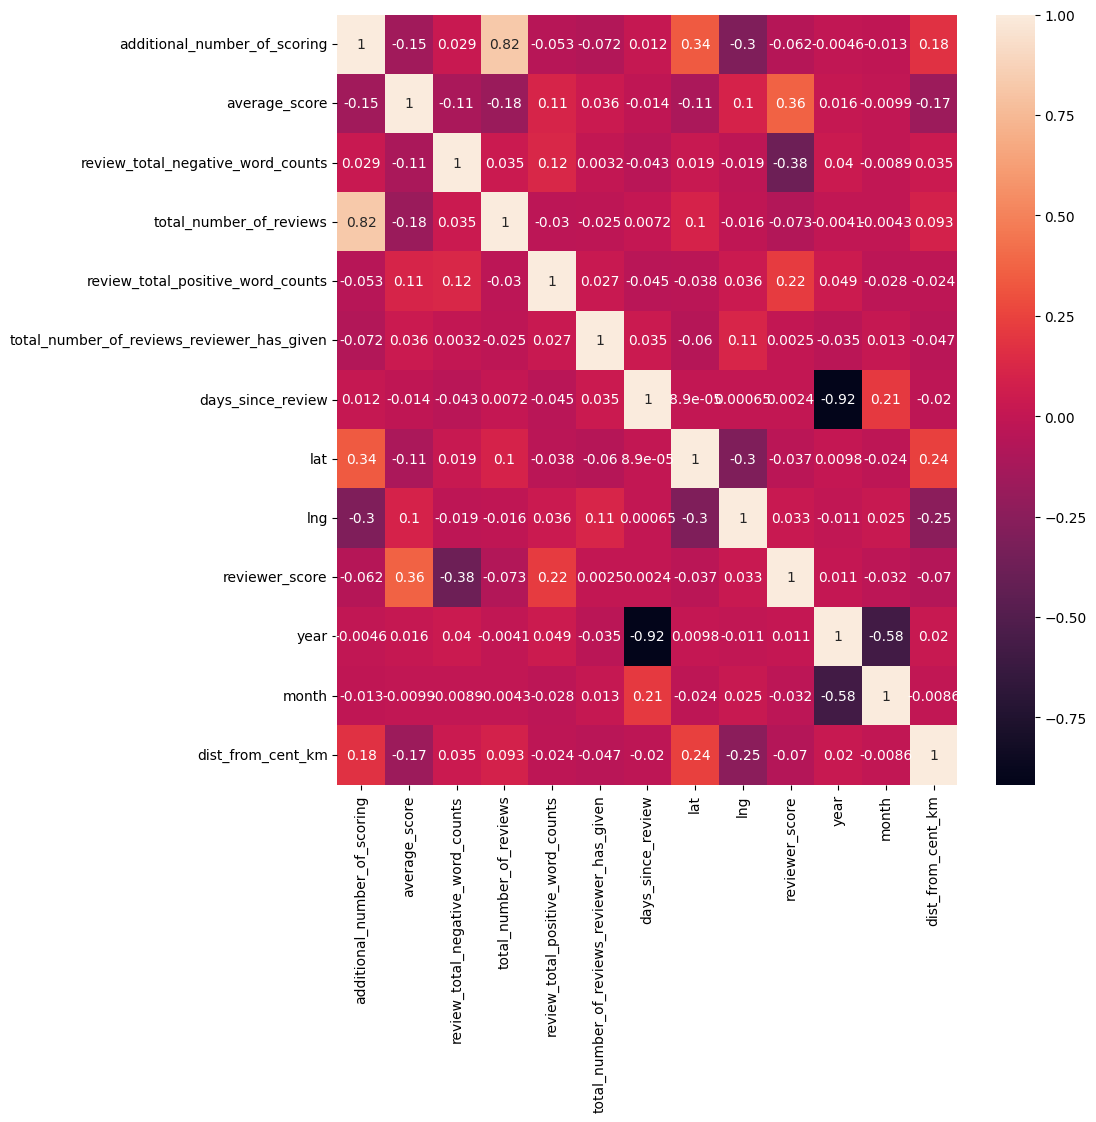

In [217]:
# Посмотрим на тепловую матрицу корреляции числовых признаков:

sns.heatmap(df.corr(), annot = True)

Анализирую матрицу корреляции числовых признаков мы видем сильную зависимость между признаками "additional_number_of_scoring" и "total_number_of_reviews". От одного из этих признаков нам необходимо избавиться. 
оставим признак, который имеет бОльшую взаимосвязь с целевой переменной.
Исходя из корреляции по методу Пирсона, следует избавиться от "additional_number_of_scoring", так как взаимосвязь "total_number_of_reviews" и 'reviewer_score' проявляется больше.
Однако, проверим нормальность распределения двух этих признаков.

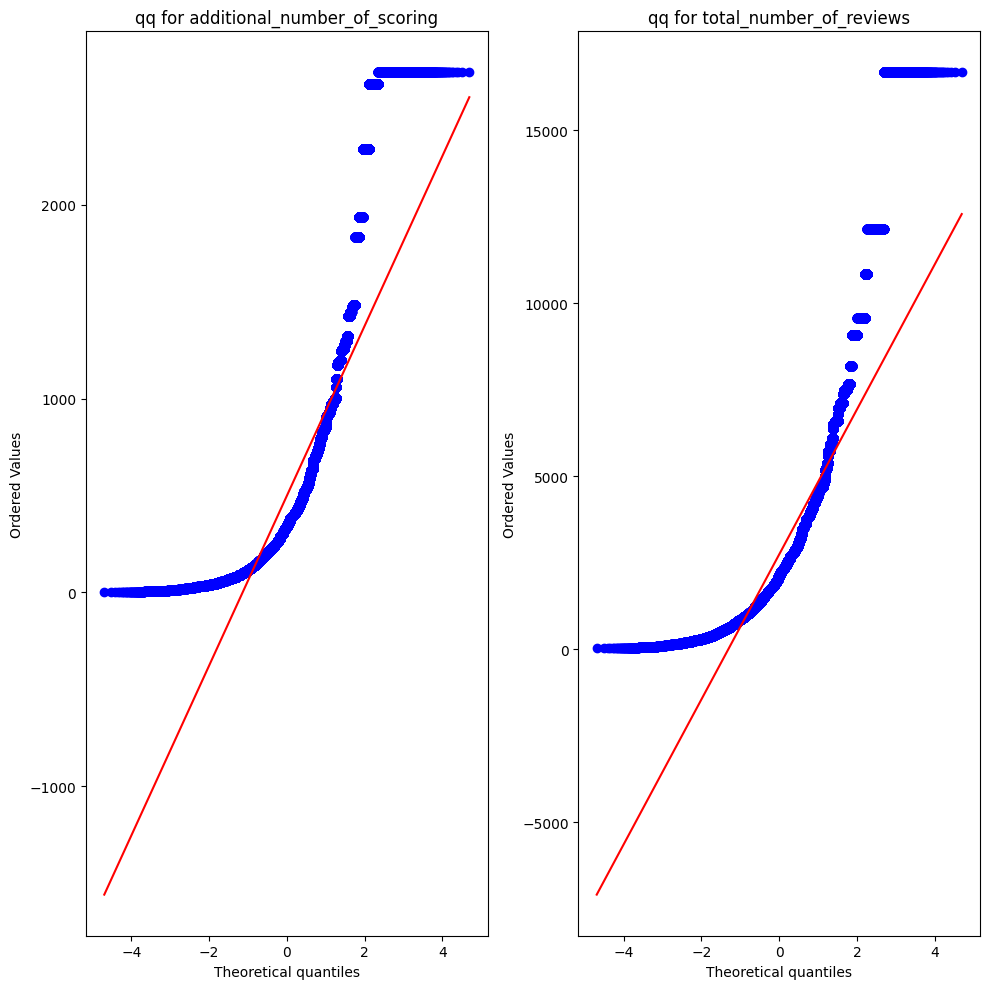

In [218]:
# Построим qq plot графики для двух признаков, чтобы оценить нормальность их распределения.

plt.subplot(1, 2, 1) # задаем сетку рисунка количество строк и столбцов
stats.probplot(df['additional_number_of_scoring'], plot=plt) # qq plot
plt.title('qq for additional_number_of_scoring')

plt.subplot(1, 2, 2) # располагаем второй рисунок рядом
stats.probplot(df['total_number_of_reviews'], plot=plt) # qq plot
plt.title('qq for total_number_of_reviews')

plt.tight_layout() 
plt.show() 

<AxesSubplot: >

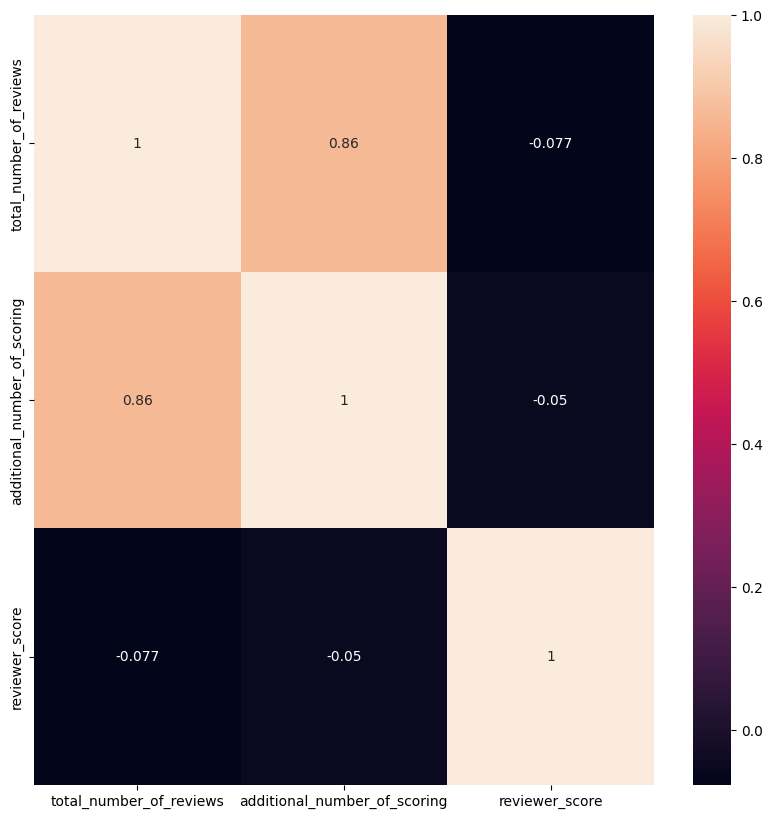

In [219]:
# Исходя из qq plot графиков выше, можно сказать, что показатели распределены ненормально. 
# Оценим взаимосвязь этих признаков с целевой переменной, использую метод Спирмена.

sns.heatmap(df[['total_number_of_reviews', 'additional_number_of_scoring', 'reviewer_score']].corr(method = 'spearman'), annot = True)


In [220]:
# Взаимосвязь признаков "total_number_of_reviews" и 'reviewer_score' при данном методе корреляции видна еще сильнее.
# C помощью статичстического теста проверим равенство диспрерсий для того, 
# чтобы понять какой тест использовать для проверки взаимосвязи признаков - параметрический или непараметрический.

# задаём уровень значимости
alpha = 0.05
result = stats.levene(df['total_number_of_reviews'], df['additional_number_of_scoring'])
p = result[1]
print('p-value = {:.3f}'.format(p))

if p <= alpha:
    print('Дисперсии не одинаковы, нужно использовать непараметрический тест')
else:
    print('Дисперсии одинаковы, мы можем использовать тест ANOVA')


p-value = 0.000
Дисперсии не одинаковы, нужно использовать непараметрический тест


In [221]:
# Дисперсии не одинаковы, нужно использовать непараметрический тест. Воспользуемся тестом хм-квадрат для проверки взаимосвязи между признаками.
# Сформулируем гипотезы:
# Нулевая гипотеза: признаки 'total_number_of_reviews'] и 'additional_number_of_scoring' независимы.
# Альтернативная гипотеза: признаки 'total_number_of_reviews'] и 'additional_number_of_scoring' взаимосвязаны.

# задаём уровень значимости
alpha = 0.05 

# вычисляем таблицу сопряжённости
table = pd.crosstab(df['total_number_of_reviews'], df['additional_number_of_scoring'])

# проводим тест
_, p, _, _ = stats.chi2_contingency(table)

print('p-value = {:.3f}'.format(p))

# интерпретируем результат
if p <= alpha:
    print('p-значение меньше, чем заданный уровень значимости {:.2f}. Отвергаем нулевую гипотезу.'.format(alpha))
else:
    print('p-значение больше, чем заданный уровень значимости {:.2f}. У нас нет оснований отвергнуть нулевую гипотезу.'.format(alpha))

p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу.


In [222]:
# p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу. Признаки зависимы.
# Так как признак 'total_number_of_reviews' имееет большую корреляцию с целевой переменной, удалим признак "additional_number_of_scoring" из наших данных.

df = df.drop("additional_number_of_scoring", axis = 1)

In [223]:
# Посмотрим на категориальные и числовые признаки

cat_cols = []
num_cols = []

for col in df.columns:
    if df[col].dtypes == 'object':
        cat_cols.append(col)
    else:
        num_cols.append(col)
        
print('Категориальные признаки:', cat_cols)
print('Числовые признаки', num_cols)

Категориальные признаки: ['hotel_address', 'hotel_name', 'reviewer_nationality', 'negative_review', 'positive_review', 'tags', 'country', 'city', 'hotel_coordinate', 'center_coordinate', 'season']
Числовые признаки ['review_date', 'average_score', 'review_total_negative_word_counts', 'total_number_of_reviews', 'review_total_positive_word_counts', 'total_number_of_reviews_reviewer_has_given', 'days_since_review', 'lat', 'lng', 'reviewer_score', 'year', 'month', 'dist_from_cent_km']


In [224]:
# Создадим датафрейм 'feature_df', в котором будем сохранить нужные нам признаки в необходимом формате для модели.

# Удалим признак 'hotel_address' так как мы получили необходимые признаки из него: страна, город.

# Признак 'hotel_name' удаляем по причине того, что попытка кодировать его приведет к увеличению размерности нашего датафрейма 
# (количество уникальных значений признака - 1492), но вероятно не даст большей точности при прогнозировании целевого признака.

# Из признака 'review_date' мы получили такие признаки как год, месяц, сезон. Удалим его.

# Удалим текстовые признаки 'negative_review', 'positive_review', 'tags'.

# 'country', 'season', 'reviewer_nationality',

# Удалим признаки 'lat', 'lng', 'hotel_coordinate', 'center_coordinate' - мы получили из этих данных информацию о том, насколько далеко отель расположен от центра города.

df['hotel_name'].nunique()
feature_df = df.copy()
feature_df = feature_df.drop(['hotel_address', 'hotel_name', 'review_date', 'negative_review', 'positive_review', 'country', 'season', 'reviewer_nationality', 'tags', 'lat', 'lng', 'city', 'hotel_coordinate', 'center_coordinate'], axis = 1)

In [225]:
# Кодируем категориальные признаки: для признаков страны, сезона года, месяца используем OneHotEncoder.
# Для признака национальности ревьюера используем BinaryEncoder, так как уникальных значений .
    
bin_encoder = ce.BinaryEncoder(cols=['reviewer_nationality']) 
type_bin = bin_encoder.fit_transform(df['reviewer_nationality'])
feature_df = pd.concat([feature_df, type_bin], axis=1)

import category_encoders as ce
encoder = ce.OneHotEncoder(cols=['country'], use_cat_names=True)
type_bin = encoder.fit_transform(df['country'])
feature_df = pd.concat([feature_df, type_bin], axis=1)


season_encoder = ce.OneHotEncoder(cols=['season'], use_cat_names=True) 
season_bin = season_encoder.fit_transform(df['season'])
feature_df = pd.concat([feature_df, season_bin], axis=1)

season_encoder = ce.OneHotEncoder(cols=['month'], use_cat_names=True) 
season_bin = season_encoder.fit_transform(df['month'])
feature_df = pd.concat([feature_df, season_bin], axis=1)

In [226]:
# Проверим датафрейм на мультиколлинеарность:

feature_df.corr(method = 'spearman') >=0.7
feature_df.corr(method = 'spearman') <=-0.7

# Сильно коррелярующих друг с другом данных нет.

,average_score,review_total_negative_word_counts,total_number_of_reviews,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,days_since_review,reviewer_score,year,month,dist_from_cent_km,reviewer_nationality_0,reviewer_nationality_1,reviewer_nationality_2,reviewer_nationality_3,reviewer_nationality_4,reviewer_nationality_5,reviewer_nationality_6,reviewer_nationality_7,country_Italy,country_Netherlands,country_Spain,country_United Kingdom,country_France,country_Austria,season_summer,season_winter,season_autumn,season_spring,month_7.0,month_12.0,month_11.0,month_10.0,month_5.0,month_8.0,month_6.0,month_9.0,month_1.0,month_3.0,month_4.0,month_2.0
average_score,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
review_total_negative_word_counts,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
total_number_of_reviews,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
review_total_positive_word_counts,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
total_number_of_reviews_reviewer_has_given,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
days_since_review,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
reviewer_score,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
year,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
month,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
dist_from_cent_km,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


In [227]:
# У нас есть три признака, относящиеся к дате, когда была дана оценка отелю: год, месяц, сезон.
# Посмотри на корреляцию данных признаков с целевой переменной:

df[['month', 'year', 'reviewer_score']].corr()

# Признак месяца имеет большую корреляцию с целевой переменной, чем год. 
# Что важнее для модели - месяц или сезон? 
# С помощью RandomForestRegressor после обучения модели и получения значение МАРЕ, выведем самые важные признаки.

,month,year,reviewer_score
month,1.000000,-0.581331,-0.032397
year,-0.581331,1.000000,0.011043
reviewer_score,-0.032397,0.011043,1.000000


In [228]:
# # Обучим модель, получим значение МАРЕ:

# train_data = feature_df[feature_df['reviewer_score'].isnull() == False]
# test_data = feature_df[feature_df['reviewer_score'].isnull() == True]

# y = train_data.reviewer_score.values            # наш таргет
# X = train_data.drop(['reviewer_score'], axis=1)

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

# test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

# # Импортируем необходимые библиотеки:
# from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
# from sklearn import metrics # инструменты для оценки точности модели

# # Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
# model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

# # Обучаем модель на тестовом наборе данных
# model.fit(X_train, y_train)

# # Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# # Предсказанные значения записываем в переменную y_pred
# y_pred = model.predict(X_test)

# # Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# # Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
# print('MAPE:', metrics.mean_absolute_error(y_test, y_pred))


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  7.7min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.5s


MAPE: 0.943982721929531


[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:   11.5s finished


<AxesSubplot: >

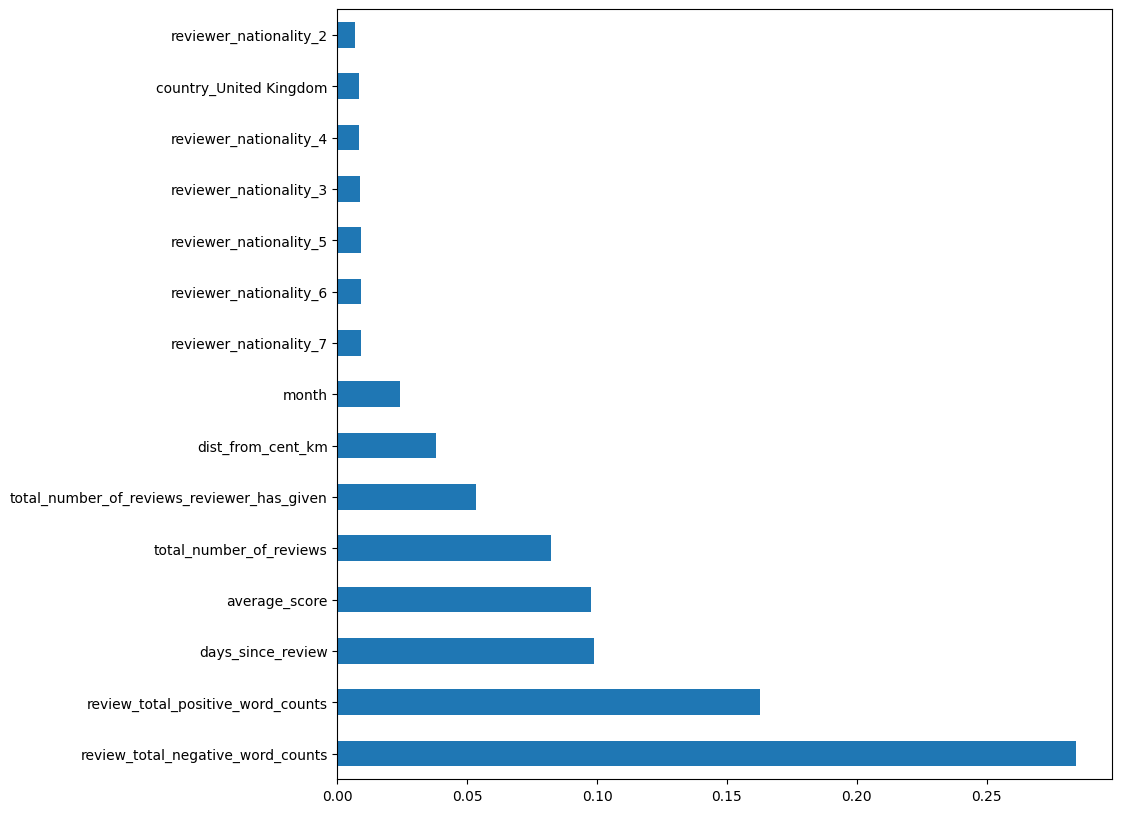

In [229]:
# # Посомтрим на самые важные признаки для модели:

# plt.rcParams['figure.figsize'] = (10,10)
# feat_importances = pd.Series(model.feature_importances_, index=X.columns)
# feat_importances.nlargest(15).plot(kind='barh')

Мы получили значение МАРЕ, а так же возможность посмотреть на самые важные признаки для модели. 
Данные о сезоне не являются одними из важных. Удалим их.
Так же проведем нормализацю некоторых признаков, после чего посмотрим на результат МАРЕ еще раз.

In [230]:
feature_df = feature_df.drop(['season_spring', 'season_autumn', 'season_summer', 'season_winter'], axis = 1)
feature_df = feature_df.drop(['month'], axis = 1)
feature_df = feature_df.drop(['year'], axis = 1)

In [231]:
# # инициализируем нормализатор RobustScaler
# r_scaler = preprocessing.RobustScaler()

# # кодируем исходный датасет
# df_r = r_scaler.fit_transform(feature_df)

# # Преобразуем промежуточный датасет в полноценный датафрейм для визуализации
# df_r = pd.DataFrame(df_r, columns=list(feature_df.columns))


In [232]:
# # Обучим модель на измененном датасете и посмотрим на результат МАРЕ:

# train_data = df_r[df_r['reviewer_score'].isnull() == False]
# test_data = df_r[df_r['reviewer_score'].isnull() == True]

# y = train_data.reviewer_score.values            # наш таргет
# X = train_data.drop(['reviewer_score'], axis=1)

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

# test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

# # Импортируем необходимые библиотеки:
# from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
# from sklearn import metrics # инструменты для оценки точности модели

# # Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
# model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

# # Обучаем модель на тестовом наборе данных
# model.fit(X_train, y_train)

# # Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# # Предсказанные значения записываем в переменную y_pred
# y_pred = model.predict(X_test)

# # Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# # Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
# print('MAPE:', metrics.mean_absolute_error(y_test, y_pred))


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  7.3min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.8s


MAPE: 0.44900771426015473


[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    8.1s finished


<AxesSubplot: >

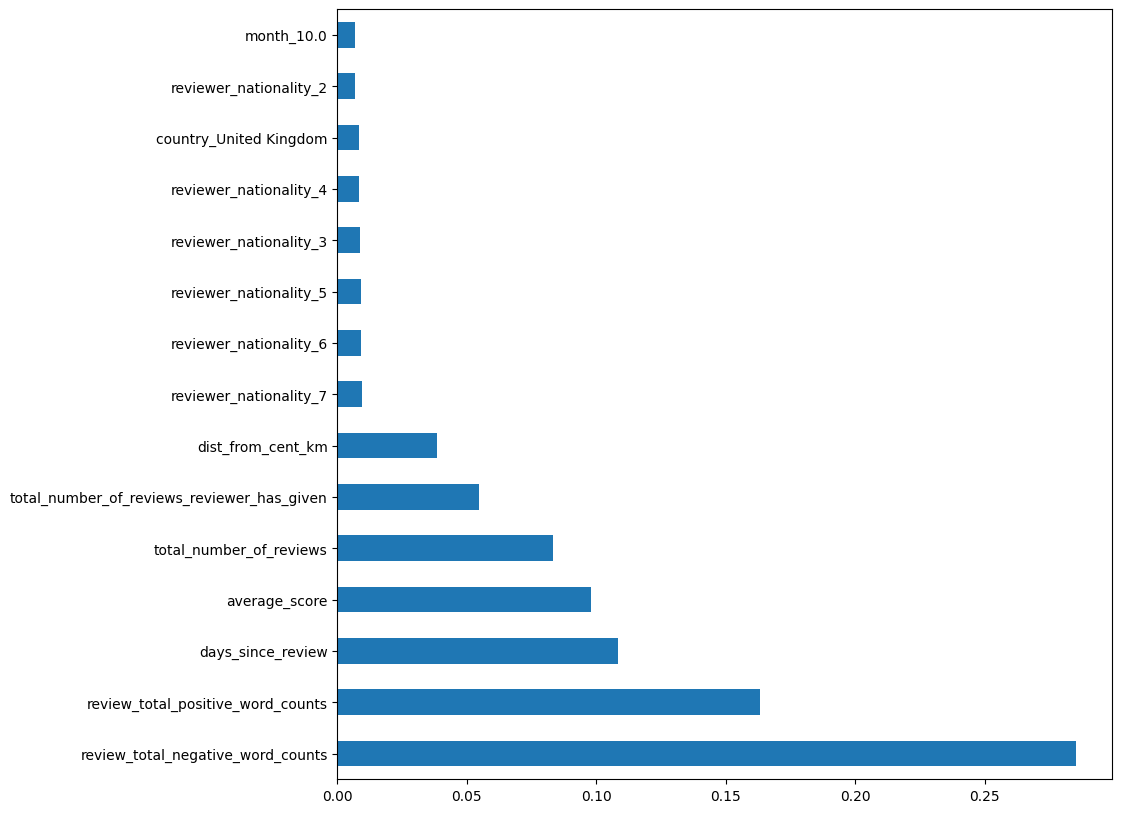

In [233]:
# # Выведем важнейшие признаки для модели:

# plt.rcParams['figure.figsize'] = (10,10)
# feat_importances = pd.Series(model.feature_importances_, index=X.columns)
# feat_importances.nlargest(15).plot(kind='barh')

Значение МАРЕ ухудшилось с нормализацией. 
Так же видно, что кодирование признака месяца привело к тому, что для модели данный признак перестал быть значимым, предсказания потеряли в точности. Откажемся от него.Так же, ставим признак месяца без кодирования. Посмотрим на предсказания еще раз.

In [234]:
feature_df['month'] = df['month']
feature_df = feature_df.drop(['month_1.0', 'month_2.0', 'month_3.0', 'month_4.0', 'month_5.0', 'month_6.0', 'month_7.0', 'month_8.0', 'month_9.0', 'month_10.0', 'month_11.0', 'month_12.0'], axis = 1)

In [ ]:
# jghj
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer

def get(text):
    sia = SentimentIntensityAnalyzer()
    return (sia.polarity_scores(text))

df['negative_review_sentiment'] = df['negative_review'].apply(get)

In [ ]:
feature_df['neg'] = df['negative_review_sentiment'].apply(lambda x: x['neg'] if x['neg'] != 0 else 0)
feature_df['neu'] = df['negative_review_sentiment'].apply(lambda x: x['neu'] if x['neu'] != 0 else 0)
feature_df['pos'] = df['negative_review_sentiment'].apply(lambda x: x['pos'] if x['pos'] != 0 else 0)

In [235]:
train_data = feature_df[feature_df['reviewer_score'].isnull() == False]
test_data = feature_df[feature_df['reviewer_score'].isnull() == True]

y = train_data.reviewer_score.values            # наш таргет
X = train_data.drop(['reviewer_score'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAPE:', metrics.mean_absolute_error(y_test, y_pred))


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  6.0min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.0s


MAPE: 0.9454571678789792


[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    9.0s finished


<AxesSubplot: >

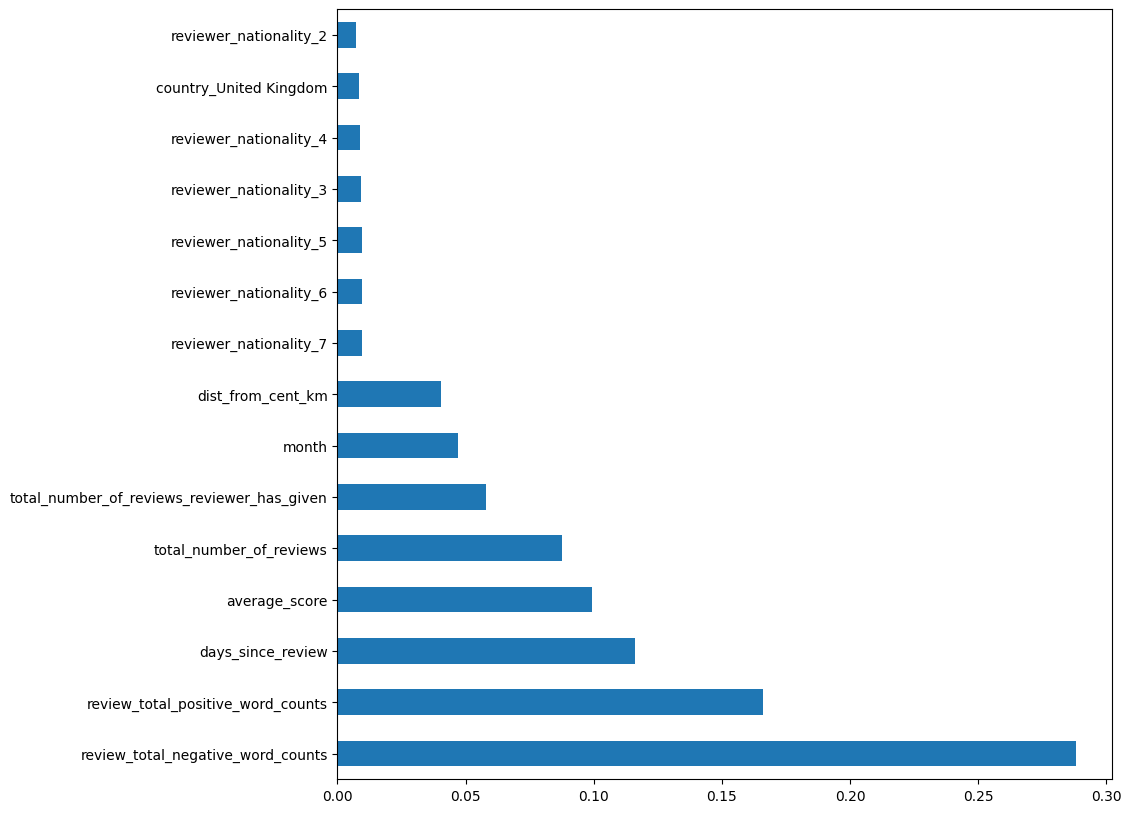

In [236]:
# Посмотрим на важные признаки:
    
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

MAPE: 0.9454571678789792
Проведя разведывательный анализ и создав модель для предсказания признака рейтинга, можно отметить, что важнейшими оказались признаки:
1) количество слов внегативном и позитивном отзыве.
Вероятно, при накрутке рейтинга, намного проще поставить оценку, без комментариев (о чем так же говорить важность признака total_number_of_reviews). Возможно, с увеличением количества слов в оставленном отзыве, можно предположить о его реальности: негативные отзывы расписываются, обычно, довольно многословно.
2) days_since_review - продолжительность между датой проверки и датой очистки
3) average_score - средний балл отеля, рассчитанный на основе последнего комментария за последний год
4) total_number_of_reviews - общее количество действительных отзывов об отеле
5) total_number_of_reviews_reviewer_has_given - количество отзывов, которые рецензенты дали в прошлом (вероятно, люди, которые оставляли больше отзывов, привыкли больше замечать детали и отдают описанию + и - большую важность)
6) месяц, в котором был оставлен отзыв, возможно, часто совпадает с месяцем посещения отеля, что может влиять на его восприятие: погода, мероприятия в городе в этом месяце, сезонная еда, и тд.
7) удаленность от центра города так же является важным для модели признаком, идея жить ближе к центру кажется более привлекательной: близость к достопримечательностям, кафе, транспорт, возможно виды из окна.
8) национальность ревьюера так же влияет на предсказние модели, вероятоно есть характерные для каждой национальности моменты, на которые обращается большее внимание или схожесть места посещения с привычной жизнью.
9) "Великобритания" так же оказалась важным фактором для модели, может быть дело в дороговизне и от того комфортабельности отелей в Лондоне.

In [237]:
# Сохраним полученный результат в нужный файл:

test_data = test_data.drop(['reviewer_score'], axis=1)
predict_submission = model.predict(test_data)
sample_submission['reviewer_score'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.4s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:   11.8s finished


,reviewer_score,id
0,8.578,488440
1,7.794,274649
2,7.621,374688
3,9.480,404352
4,9.716,451596
5,9.051,302161
6,7.874,317079
7,7.929,13963
8,8.547,159785
9,8.026,195089


In [238]:
sample_submission.info

<bound method DataFrame.info of         reviewer_score      id
0                8.578  488440
1                7.794  274649
2                7.621  374688
3                9.480  404352
4                9.716  451596
...                ...     ...
128930           8.757  495812
128931           8.874  315577
128932           8.277  511968
128933           9.556  303386
128934           7.315  103157

[128935 rows x 2 columns]>